In [1]:
import numpy as np
from astropy.io import fits
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path
from skimage.transform import resize

In [2]:
batch_size = 32

In [3]:
transformer = transforms.Compose([ transforms.ToTensor(), transforms.Normalize([10],[1]) ])

In [4]:
IMG_EXTENSIONS = [
    ".fits"
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images


def default_fits_loader(file_name: str, img_size: tuple, slice_index):
    file = fits.open(file_name)
    _data = file[1].data
    _data = resize(_data[slice_index], img_size)
    _label = file[0].header['LABEL']

    if len(_data.shape) < 3:
        _data = _data.reshape((*_data.shape, 1))
    
    return _data, _label


class FITSCubeDataset(data.Dataset):
    def __init__(self, data_path, cube_length, transforms, img_size):
        self.data_path = data_path
        self.transforms = transforms
        self.img_size = img_size
        self.cube_length = cube_length
        self.img_files = make_dataset(data_path)

    def __getitem__(self, index):
        cube_index = index // self.cube_length
        slice_index = index % self.cube_length
        _img, _label = default_fits_loader(self.img_files[cube_index], self.img_size, slice_index)
        if self.transforms is not None:
            _data = (self.transforms(_img), _label)
        else:
            _data = (_img, _label)
            
        return _data

    def __len__(self):
        return len(self.img_files)*self.cube_length


In [5]:
CUBE_LENGTH = 640
trainset = FITSCubeDataset("E:/Documents/Python_Scripts/CNN/TRAINING/EXAMPLES/",CUBE_LENGTH,transformer,(64,64))

In [6]:
start = time.time()
train_loader = torch.utils.data.DataLoader(trainset, batch_size=9*640,shuffle=False)
dataiter = iter(train_loader)
images, labels = dataiter.next()
end = time.time()
print('LOAD TIME:')
print('%.2gs'%(end-start))

C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


LOAD TIME:
21s


In [7]:
weight_array = np.zeros(9)

for i in range(len(labels)):
    if labels[i] == 1:
        weight_array[0]+=1
    if labels[i] == 2:
        weight_array[1]+=1
    if labels[i] == 3:
        weight_array[2]+=1
    if labels[i] == 4:
        weight_array[3]+=1
    if labels[i] == 5:
        weight_array[4]+=1
    if labels[i] == 6:
        weight_array[5]+=1
    if labels[i] == 7:
        weight_array[6]+=1
    if labels[i] == 8:
        weight_array[7]+=1
    if labels[i] == 9:
        weight_array[8]+=1
        
print(weight_array)

[640. 640. 640. 640. 640. 640. 640. 640. 640.]


In [8]:
weights_final = (len(labels)-weight_array)/len(labels)
print(weights_final)

[0.88888889 0.88888889 0.88888889 0.88888889 0.88888889 0.88888889
 0.88888889 0.88888889 0.88888889]


In [9]:
weight_array2 = []

for i in range(len(labels)):
    if labels[i] == 1:
        weight_array2.append(weights_final[0])
    if labels[i] == 2:
        weight_array2.append(weights_final[1])
    if labels[i] == 3:
        weight_array2.append(weights_final[2])
    if labels[i] == 4:
        weight_array2.append(weights_final[3])
    if labels[i] == 5:
        weight_array2.append(weights_final[4])
    if labels[i] == 6:
        weight_array2.append(weights_final[5])
    if labels[i] == 7:
        weight_array2.append(weights_final[6])
    if labels[i] == 8:
        weight_array2.append(weights_final[7])
    if labels[i] == 9:
        weight_array2.append(weights_final[8])
        

print(np.unique(weight_array2))

[0.88888889]


In [10]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_array2, len(weight_array2))

In [11]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,sampler = sampler)

C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


tensor([ 6,  4,  7,  7,  7,  2,  2,  3,  9,  4,  4,  6,  5,  8,
         3,  9,  7,  5,  4,  4,  3,  7,  9,  8,  9,  4,  1,  6,
         1,  1,  8,  4])


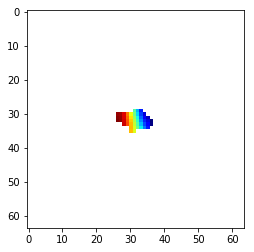

-3.436722078665002
46.43209677811848


In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)
plt.figure()
plt.imshow(images[0,0,:,:],cmap='jet')
plt.show()
print(np.nanmean((images[0,0,:,:]).numpy()))
print(np.nanstd((images[0,0,:,:]).numpy()))

In [13]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data)
        m.bias.data.zero_()

In [14]:
### VGG LIKE MODEL ###

class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,64,5,padding=2),
            nn.ReLU(), 
            nn.Conv2d(64,128,5,padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,5,padding=2),
            nn.ReLU(),
            nn.Conv2d(256,512,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Conv2d(512,512,3,padding=1), 
            nn.ReLU(),
            nn.Conv2d(512,512,3,padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Conv2d(512,256,3,padding=1), 
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Conv2d(256,128,3,padding=1), 
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
            nn.Linear(128*2*2,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,9))
                
    def forward(self,x):
        features = self.feature_extractor(x)
        output = self.classifier(features.view(int(x.size()[0]),-1))
        #output= F.log_softmax(output,dim=1) # Give results using softmax
        return output
  
model = Net()
model.apply(weight_init)
model.float()
model.cuda()
print(model) 

C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(512, eps=1e-05, momentum=0.1, 

In [31]:
### SIMPLE MODEL ###

class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        self.feature_extractor = nn.Sequential(
            
            nn.Conv2d(1,64,5,padding=2), # 1 input, 32 out, filter size = 5x5, 2 block outer padding
            nn.ReLU(),
            nn.Conv2d(64,128,5,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128,256,5,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2))
 
        self.classifier = nn.Sequential(
            nn.Linear(256*16*16,256), # Fully connected layer 
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,9))
        
    def forward(self,x):
        features = self.feature_extractor(x)
#        output = self.classifier(features.view(int(x.size()[0]),-1))
        output= F.log_softmax(self.classifier(features.view(int(x.size()[0]),-1)),dim=1) # Give results using softmax
        return output
  
model = Net()
model.apply(weight_init)
model.float()
model.cuda()
print(model) 

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=9, bias=True)
  )
)


C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [141]:
### MSE loss with single output ###

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True

start = time.time()
model.train()
train_loss = []
train_accu = []
i = 0
for epoch in range(25):
    scheduler.step()
    for image, label in train_loader:
        data, target = image.float().cuda(), label.float().cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target.view(output.size())) # Negative log likelihood (goes with softmax). 
        loss.backward()    # calc gradients
        train_loss.append(loss.data[0]) # Calculating the loss
        optimizer.step()   # update gradients
        prediction = torch.floor(output).int()   # first column has actual prob.

        accuracy = (prediction.eq(target.view(output.size()).int()).sum().float()/batch_size)*100
        train_accu.append(accuracy)
        if i % 10 == 0:
            print('Epoch:',str(epoch),'Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data[0], accuracy))
            #print('TARGET:',target)
            #print('OUTPUT:',output.view(target.size()))
        i += 1
end = time.time()
print('TRAIN TIME:')
print('%.2gs'%(end-start))



C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.ite

Epoch: 0 Train Step: 0	Loss: 6.562	Accuracy: 12.500
Epoch: 0 Train Step: 10	Loss: 5.717	Accuracy: 12.500
Epoch: 0 Train Step: 20	Loss: 5.816	Accuracy: 21.875
Epoch: 0 Train Step: 30	Loss: 5.850	Accuracy: 12.500
Epoch: 0 Train Step: 40	Loss: 7.141	Accuracy: 3.125
Epoch: 0 Train Step: 50	Loss: 6.522	Accuracy: 6.250
Epoch: 0 Train Step: 60	Loss: 7.089	Accuracy: 12.500
Epoch: 0 Train Step: 70	Loss: 5.970	Accuracy: 25.000
Epoch: 0 Train Step: 80	Loss: 5.604	Accuracy: 21.875
Epoch: 0 Train Step: 90	Loss: 7.301	Accuracy: 18.750
Epoch: 0 Train Step: 100	Loss: 7.570	Accuracy: 9.375
Epoch: 0 Train Step: 110	Loss: 8.243	Accuracy: 9.375
Epoch: 0 Train Step: 120	Loss: 6.251	Accuracy: 9.375
Epoch: 0 Train Step: 130	Loss: 5.746	Accuracy: 6.250
Epoch: 0 Train Step: 140	Loss: 6.680	Accuracy: 9.375
Epoch: 0 Train Step: 150	Loss: 5.404	Accuracy: 21.875
Epoch: 0 Train Step: 160	Loss: 5.895	Accuracy: 15.625
Epoch: 0 Train Step: 170	Loss: 5.715	Accuracy: 12.500
Epoch: 1 Train Step: 180	Loss: 7.392	Accuracy:

Epoch: 8 Train Step: 1530	Loss: 9.036	Accuracy: 9.375
Epoch: 8 Train Step: 1540	Loss: 8.009	Accuracy: 12.500
Epoch: 8 Train Step: 1550	Loss: 7.373	Accuracy: 15.625
Epoch: 8 Train Step: 1560	Loss: 7.259	Accuracy: 9.375
Epoch: 8 Train Step: 1570	Loss: 7.628	Accuracy: 12.500
Epoch: 8 Train Step: 1580	Loss: 8.650	Accuracy: 9.375
Epoch: 8 Train Step: 1590	Loss: 6.312	Accuracy: 12.500
Epoch: 8 Train Step: 1600	Loss: 5.856	Accuracy: 12.500
Epoch: 8 Train Step: 1610	Loss: 7.246	Accuracy: 9.375
Epoch: 9 Train Step: 1620	Loss: 5.231	Accuracy: 12.500
Epoch: 9 Train Step: 1630	Loss: 6.091	Accuracy: 9.375
Epoch: 9 Train Step: 1640	Loss: 7.556	Accuracy: 9.375
Epoch: 9 Train Step: 1650	Loss: 7.553	Accuracy: 6.250
Epoch: 9 Train Step: 1660	Loss: 8.999	Accuracy: 3.125
Epoch: 9 Train Step: 1670	Loss: 7.453	Accuracy: 18.750
Epoch: 9 Train Step: 1680	Loss: 5.417	Accuracy: 15.625
Epoch: 9 Train Step: 1690	Loss: 5.994	Accuracy: 12.500
Epoch: 9 Train Step: 1700	Loss: 5.975	Accuracy: 25.000
Epoch: 9 Train Ste

Epoch: 16 Train Step: 3020	Loss: 5.953	Accuracy: 6.250
Epoch: 16 Train Step: 3030	Loss: 4.718	Accuracy: 18.750
Epoch: 16 Train Step: 3040	Loss: 5.817	Accuracy: 18.750
Epoch: 16 Train Step: 3050	Loss: 6.993	Accuracy: 6.250
Epoch: 17 Train Step: 3060	Loss: 6.133	Accuracy: 6.250
Epoch: 17 Train Step: 3070	Loss: 6.197	Accuracy: 3.125
Epoch: 17 Train Step: 3080	Loss: 4.998	Accuracy: 21.875
Epoch: 17 Train Step: 3090	Loss: 7.611	Accuracy: 6.250
Epoch: 17 Train Step: 3100	Loss: 5.470	Accuracy: 12.500
Epoch: 17 Train Step: 3110	Loss: 6.353	Accuracy: 6.250
Epoch: 17 Train Step: 3120	Loss: 5.521	Accuracy: 9.375
Epoch: 17 Train Step: 3130	Loss: 5.230	Accuracy: 18.750
Epoch: 17 Train Step: 3140	Loss: 6.343	Accuracy: 15.625
Epoch: 17 Train Step: 3150	Loss: 6.177	Accuracy: 12.500
Epoch: 17 Train Step: 3160	Loss: 5.881	Accuracy: 9.375
Epoch: 17 Train Step: 3170	Loss: 6.746	Accuracy: 15.625
Epoch: 17 Train Step: 3180	Loss: 6.128	Accuracy: 18.750
Epoch: 17 Train Step: 3190	Loss: 6.602	Accuracy: 12.500


TRAIN TIME:
7.6e+02s


In [ ]:
### NLL loss with softmax training ###

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True

start = time.time()
model.train()
train_loss = []
train_accu = []
i = 0
for epoch in range(150):
    for image, label in train_loader:
        data, target = image.float().cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # Negative log likelihood (goes with softmax). 
        loss.backward()    # calc gradients
        train_loss.append(loss.data[0]) # Calculating the loss
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1] + 1  # first column has actual prob.
        accuracy = (prediction.eq(target.data).float().sum()/batch_size)*100
        train_accu.append(accuracy)
        if i % 10 == 0:
            print('Epoch:',str(epoch),'Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data[0], accuracy))
        i += 1
end = time.time()
print('TRAIN TIME:')
print('%.2gs'%(end-start))

C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
C:\Users\SpaceMeerkat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in

Epoch: 0 Train Step: 0	Loss: 2.168	Accuracy: 3.125
Epoch: 0 Train Step: 10	Loss: 2.170	Accuracy: 3.125
Epoch: 0 Train Step: 20	Loss: 2.151	Accuracy: 3.125
Epoch: 0 Train Step: 30	Loss: 2.207	Accuracy: 9.375
Epoch: 0 Train Step: 40	Loss: 2.219	Accuracy: 6.250
Epoch: 0 Train Step: 50	Loss: 2.215	Accuracy: 12.500
Epoch: 0 Train Step: 60	Loss: 2.185	Accuracy: 9.375
Epoch: 0 Train Step: 70	Loss: 2.194	Accuracy: 12.500
Epoch: 0 Train Step: 80	Loss: 2.195	Accuracy: 12.500
Epoch: 0 Train Step: 90	Loss: 2.251	Accuracy: 6.250
Epoch: 0 Train Step: 100	Loss: 2.216	Accuracy: 9.375
Epoch: 0 Train Step: 110	Loss: 2.208	Accuracy: 6.250
Epoch: 0 Train Step: 120	Loss: 2.234	Accuracy: 0.000
Epoch: 0 Train Step: 130	Loss: 2.204	Accuracy: 12.500
Epoch: 0 Train Step: 140	Loss: 2.149	Accuracy: 3.125
Epoch: 0 Train Step: 150	Loss: 2.217	Accuracy: 0.000
Epoch: 0 Train Step: 160	Loss: 2.121	Accuracy: 6.250
Epoch: 0 Train Step: 170	Loss: 2.158	Accuracy: 9.375
Epoch: 1 Train Step: 180	Loss: 2.217	Accuracy: 6.250


Epoch: 8 Train Step: 1530	Loss: 2.249	Accuracy: 0.000
Epoch: 8 Train Step: 1540	Loss: 2.274	Accuracy: 0.000
Epoch: 8 Train Step: 1550	Loss: 2.215	Accuracy: 6.250
Epoch: 8 Train Step: 1560	Loss: 2.213	Accuracy: 9.375
Epoch: 8 Train Step: 1570	Loss: 2.201	Accuracy: 6.250
Epoch: 8 Train Step: 1580	Loss: 2.186	Accuracy: 21.875
Epoch: 8 Train Step: 1590	Loss: 2.224	Accuracy: 9.375
Epoch: 8 Train Step: 1600	Loss: 2.121	Accuracy: 15.625
Epoch: 8 Train Step: 1610	Loss: 2.184	Accuracy: 9.375
Epoch: 9 Train Step: 1620	Loss: 2.208	Accuracy: 15.625
Epoch: 9 Train Step: 1630	Loss: 2.213	Accuracy: 6.250


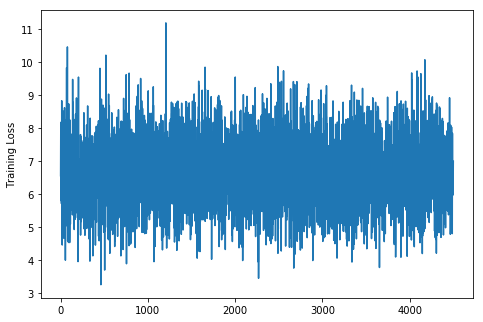

In [142]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.plot(np.arange(len(train_loss)),train_loss)
plt.ylabel('Training Loss')
plt.show()
fig.savefig('loss.png',bbox_inches='tight')

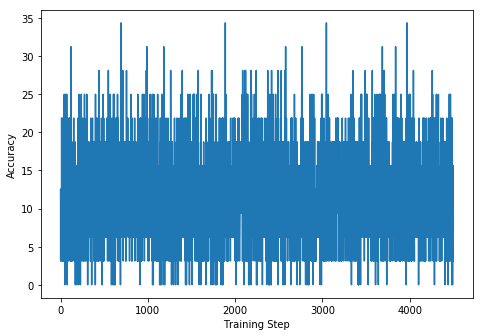

In [143]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.plot(np.arange(len(train_accu)), train_accu)
plt.ylabel('Accuracy')
plt.xlabel('Training Step')
plt.show()
fig.savefig('accuracy2.png',bbox_inches='tight')